# Setup

In [22]:
from dotenv import load_dotenv
load_dotenv()

True

## LLM

In [23]:
import os
from langchain_openai import AzureChatOpenAI

# TODO: Add Ollama alternative

############### Init LLM ###############
llm = AzureChatOpenAI(
    api_key=os.getenv("AZURE_OPENAI_API_KEY"),
    azure_endpoint=os.getenv("AZURE_OPENAI_ENDPOINT"),
    azure_deployment=os.getenv("AZURE_OPENAI_DEPLOYMENT_NAME"),
    openai_api_version=os.getenv("AZURE_OPENAI_API_VERSION"),
)

## DB

In [24]:
import sqlite3
db_path = "db/students/students.db"
student_db = sqlite3.connect(db_path, check_same_thread=False)
student_db_cursor = student_db.cursor()

### Test DB

In [25]:
all = student_db_cursor.execute('SELECT * FROM students')
all.fetchall()

[(1,
  'wondergirl',
  'Alice',
  'Alice is a quiet girl who wants to get better at math'),
 (2, 'builderboy', 'Bob', 'Bob has trouble remembering his dates in history')]

# State

In [26]:
from typing import Optional
from pydantic import BaseModel, Field
from langgraph.graph import MessagesState

class Student(BaseModel):
    ''' Class for agent to fill out, which fits with SQL table '''
    
    username: str = Field(description='The username for the student, which is a unique identifier')
    name: Optional[str] = Field(None, description='Name of student')
    summary: Optional[str] = Field(None, description='A summary of the students profile, based on available fields')
    @property
    def persona(self) -> str:
        return f"Username:\n {self.username}\n Name:\n {self.name}\nSummary\n {self.summary}"

# Graph state
class StudyAgentState(MessagesState):
    username: str
    student: Optional[Student]
    max_messages: int

# Load Student

In [27]:
def fetch_student_profile(username: str) -> Student:
    ''' Retrieve student profile if existing '''
    
    # Connect to the SQLite database (adjust the path to your database file)
    connection = sqlite3.connect(db_path)
    cursor = connection.cursor()

    # Execute the query to search for the student by username
    cursor.execute('SELECT * FROM students WHERE username = ?', (username,))

    # Fetch the result
    student_data = cursor.fetchone()

    # Close the connection
    cursor.close()
    connection.close()

    # If a student is found, return a Student object, otherwise return None
    if student_data:
        _, username, name, summary = student_data
        return Student(username=username, name=name, summary=summary)
    else:
        return Student(username=username)

In [28]:
none_ = fetch_student_profile('wondergirl')
none_

Student(username='wondergirl', name='Alice', summary='Alice is a quiet girl who wants to get better at math')

In [29]:
def load_user(state: StudyAgentState) -> StudyAgentState:
    ''' Loading user from SQL based on username, if it exists '''
    print('--- Loading Student ---')
    username = state['username']
    student = fetch_student_profile(username)
    # print(f'Student: \n {student}')
    return {'student': student}

# Agent

In [30]:
from langchain_core.messages import SystemMessage

agent_prompt = ''' 
You are a helpful and personalized study agent. Your goal is to assist students with their questions while also building a complete profile of their study habits and areas of focus to help them better. Follow these instructions carefully:

1. **Profile Checking**:
    - First, review the student's current profile. If the profile is missing key information (e.g., name or summary), ask the student to provide the missing details.
    - Use any available context from the conversation to fill in or update fields like their name or summary.

2. **Updating the Profile**:
    - If new information is provided by the student during the conversation, tag this data within the response using the following format:
      `<student_profiling>`[extracted information]</student_profiling>.
    - This information should include the student's name, learning focus, or any other relevant details that are missing or need to be updated.

3. **Answering Questions**:
    - Once you have gathered sufficient information, proceed to answer the student's question.
    - For general or factual questions (e.g., "What is pi?"), provide a concise, accurate answer. If the student's profile is incomplete, make sure to ask any necessary questions to fill in missing details after answering.

4. **Profile Enrichment**:
    - Use the context of the student's questions to enrich their profile. If they ask multiple questions related to a subject (e.g., math), update the summary to reflect this focus.
    - Tag any newly extracted information about the student in your response with `<student_profiling>` tags.

5. **Tone**:
    - Be polite, friendly, and encouraging in your responses. Make the process of answering questions and gathering profile information smooth and non-intrusive.

If you think there is any new and important information about the student in your correspondance, tag the relevant information
`<student_profiling>[extracted information]</student_profiling>`.
Only add this tag, if there is something important to add to the existing profile.
Don't send the same information within the tag more than once
Add the tag to the end of your message.
Formulate the message, so it still makes sense when the student profiling tag is removed.
'''

def agent(state: StudyAgentState):
    ''' Node for gathering basic info on the student '''
    print('--- Agent ---')
    student = state['student']
    messages = state['messages']

    sys_msg = agent_prompt
    if student.summary is not None:
        sys_msg += f'\n\nHere is a summary of what you know about the student so far:\n{student.persona}'

    answer = llm.invoke([SystemMessage(content=sys_msg)] + messages)
    print(answer.content)
    
    return {'messages': answer}

# Update student profile

In [31]:
def update_db(student: Student) -> None:
    ''' Update student profile if existing '''
    print('--- Updating DB ---')
    # Connect to the SQLite database (adjust the path to your database file)
    connection = sqlite3.connect(db_path)
    cursor = connection.cursor()

    # Execute the query to upsert the student
    cursor.execute(
        '''
        INSERT INTO students (username, name, summary)
        VALUES (:username, :name, :summary)
        ON CONFLICT(username) 
        DO UPDATE SET 
            name = excluded.name,
            summary = excluded.summary;
        ''', 
        {
            'username': student.username,
            'name': student.name,
            'summary': student.summary
        }
    )

    # Commit the transaction to save the changes
    connection.commit()

    # Close the connection
    cursor.close()
    connection.close()

    print('DB updated')

In [32]:
from langchain_core.messages import SystemMessage, HumanMessage, AIMessage, RemoveMessage

update_student_prompt = ''' 
You are tasked with updating the profile of the following student. The student's current profile will be provided below. Review the profile and update any missing or incomplete fields, including the student's name and summary.

- If the student's name is missing or incorrect, suggest an appropriate name or confirm the correct name if possible.
- If the summary is incomplete, add relevant details to provide a more complete profile of the student's academic background or learning habits.
- Do not modify the username, as it is a unique identifier.

Here is the student's current profile:
Username: {student_username}
Name: {student_name}
Summary: {student_summary}

Here is what was extracted from the agent:
{extracted_info}

Please provide the updated profile with all relevant fields filled in. If a field is already complete, leave it unchanged.
'''

def update_student_profile(state: StudyAgentState):
    """ Node for updating the student profile """
    print('--- Updating student ---')
    student = state['student']
    messages = state['messages']
    last_message = messages[-1]

    # Check if <student_profiling> tag exists in the last message content
    if "student_profiling>" in last_message.content:
        clean_message = last_message.content.split("<student_profiling>")[0] + last_message.content.split("</student_profiling>")[1].strip()
    else:
        clean_message = last_message.content

    extracted_info = last_message.content.split("student_profiling>")[1].split("</")[0].strip()

    formatted_prompt = update_student_prompt.format(
        student_username=student.username,
        student_name=student.name if student.name else "Not Provided",
        student_summary=student.summary if student.summary else "Not Provided",
        extracted_info=extracted_info
    )

    structured_llm = llm.with_structured_output(Student)
    updated_student = structured_llm.invoke(
        [SystemMessage(content=formatted_prompt)] + 
        [HumanMessage(content=f'Student to update: \n {student.persona}')] +
        messages
    )

    print(f'Student before: \n {student}')
    print(f'Updated student: \n {updated_student}')
    
    update_done_msg = AIMessage(clean_message)
    
    update_db(updated_student)

    print(f'Message: \n {clean_message}')
    print('--- END ---')
    return {'student': updated_student, 'messages': [RemoveMessage(id=last_message.id)] + [update_done_msg]}

# Routing

In [33]:
from langgraph.graph import END
from typing_extensions import Literal

def profile_router(state: StudyAgentState) -> Literal["update_student_profile", "__end__"]:
    """Determine whether to route to the update student node or end the conversation.

    Args:
        state (StudyAgentState): The current state of the conversation.

    Returns:
        Literal["update_student_profile", "__end__"]: The next step in the graph.
    """
    print('--- Routing ---')

    messages = state['messages']
    max_messages = state['max_messages']
    last_message = messages[-1]
    
    if len(messages) > max_messages:
        print('Correspondence too long, ending conversation')
        return END
    
    if '<student_profiling>' in last_message.content:
        print(f'student needs updating')
        return "update_student"
    
    print('--- End ---')
    return END

# Graph

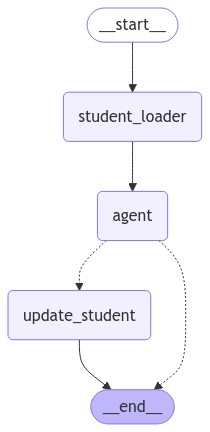

In [34]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START
from langgraph.checkpoint.memory import MemorySaver

studyagent_workflow = StateGraph(StudyAgentState)

studyagent_workflow.add_node('student_loader', load_user)
studyagent_workflow.add_node('agent', agent)
studyagent_workflow.add_node('update_student', update_student_profile)

studyagent_workflow.add_edge(START, 'student_loader')
studyagent_workflow.add_edge('student_loader', 'agent')
studyagent_workflow.add_edge('update_student', END) #'agent'
studyagent_workflow.add_conditional_edges('agent', profile_router, ['update_student', END])

memory = MemorySaver()
studyagent_graph = studyagent_workflow.compile(checkpointer=memory)

display(Image(studyagent_graph.get_graph().draw_mermaid_png()))

# Test

In [38]:
from langchain_core.messages import HumanMessage

config = {'configurable': {'thread_id': '13'}}
username = 'Lasse'
max_num_messages = 9
question = 'Hi im lasse, im 8 years old. Can you help me plan for studying for my counting exam?'

res = studyagent_graph.invoke({'messages': HumanMessage(content=question), 'username': username, 'max_messages': max_num_messages}, config)
print(studyagent_graph.get_state(config).values['student'])

--- Loading Student ---
--- Agent ---
Hello Lasse, nice to meet you! Of course, I can help you prepare for your counting exam. Let's start by planning your study schedule.

1. **Review the Basics**: Make sure you understand the basics of counting. Start from 1 and go as high as you can. Practice this daily.

2. **Count Objects**: Practice counting objects around your house, like your toys or books. This will help you understand the concept better.

3. **Count in Twos, Fives, and Tens**: Once you're comfortable with counting from 1 to 100, start practicing counting in twos, fives, and tens. This will help you count faster and more accurately.

4. **Practice Worksheets**: If you have any worksheets from school, practice them. This will give you a good idea of what to expect in the exam.

5. **Rest**: Remember to take breaks and get a good night's sleep before your exam. Your brain needs rest to perform at its best.

Remember, practice makes perfect. So keep practicing and you'll do great

In [36]:
query = 'Yes, my name is Cevin and im studying literature'

res = studyagent_graph.invoke({'messages': HumanMessage(content=query), 'username': username}, config)

--- Loading Student ---
--- Agent ---
Hi Cevin, it's nice to meet you! I'm here to help you with any questions you might have about literature or any other subject. How may I assist you in your literature studies today? <student_profiling>Name: Cevin, Learning focus: Literature</student_profiling>
--- Routing ---
student needs updating
--- Updating student ---
Student before: 
 username='Cevin' name=None summary=None
Updated student: 
 username='Cevin' name='Cevin' summary='Cevin is a student with a focus on Literature studies.'
--- Updating DB ---
DB updated
Message: 
 Hi Cevin, it's nice to meet you! I'm here to help you with any questions you might have about literature or any other subject. How may I assist you in your literature studies today? 
--- END ---


In [37]:
query = 'How can i learn more about pythagoras? I got a midterm coming up in 4 weeks'

res = studyagent_graph.invoke({'messages': HumanMessage(content=query), 'username': username}, config)

--- Loading Student ---
--- Agent ---
There are several ways you can learn more about Pythagoras and his theorem:

1. **Books and Textbooks**: There are plenty of books on Pythagoras and his theorem. You may already have a textbook for your course that covers his theorem in detail.

2. **Online Resources**: Websites like Khan Academy and Coursera offer free lessons on Pythagorean theorem. You can also find lectures on YouTube.

3. **Study Groups**: Joining study groups can be very helpful. You can discuss the topic and ask questions.

4. **Tutoring**: You can also seek help from a tutor who can explain the theorem in a way that best suits your learning style.

Remember, practice is the key when it comes to math. Solve as many problems as you can. This will not only help you understand the theorem better, but it will also help you prepare for your midterm.

I notice that you're studying literature but are now delving into a math topic. Do you also have a keen interest in mathematics or 